<h1> Logistic Regression using Spark ML </h1>

Set up bucket

In [1]:
BUCKET='cloud-training-demos-ml'

os.environ['BUCKET'] = BUCKET

In a standalone script, we'd have to do:
<pre>
from pyspark.sql import SparkSession
from pyspark import SparkContext

sc = SparkContext('local', 'logistic')
spark = SparkSession \
    .builder \
    .appName("Logistic regression w/ Spark ML") \
    .getOrCreate()

</pre>
But in Datalab, spark and sc already exist

In [2]:
print spark
print sc

In [3]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.mllib.regression import LabeledPoint

<h2> Read dataset </h2>

In [5]:
traindays = spark.read \
    .option("header", "true") \
    .csv('gs://{}/flights/trainday.csv'.format(BUCKET))
traindays.createOrReplaceTempView('traindays')

In [14]:
spark.sql("SELECT * from traindays LIMIT 5").show()

+----------+------------+
|   FL_DATE|is_train_day|
+----------+------------+
|2015-01-01|        True|
|2015-01-02|       False|
|2015-01-03|       False|
|2015-01-04|        True|
|2015-01-05|        True|
+----------+------------+



In [6]:
from pyspark.sql.types import StringType, FloatType, StructType, StructField

header = 'FL_DATE,UNIQUE_CARRIER,AIRLINE_ID,CARRIER,FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,ARR_TIME,ARR_DELAY,CANCELLED,CANCELLATION_CODE,DIVERTED,DISTANCE,DEP_AIRPORT_LAT,DEP_AIRPORT_LON,DEP_AIRPORT_TZOFFSET,ARR_AIRPORT_LAT,ARR_AIRPORT_LON,ARR_AIRPORT_TZOFFSET,EVENT,NOTIFY_TIME'

def get_structfield(colname):
   if colname in ['ARR_DELAY', 'DEP_DELAY', 'DISTANCE', 'TAXI_OUT']:
      return StructField(colname, FloatType(), True)
   else:
      return StructField(colname, StringType(), True)

schema = StructType([get_structfield(colname) for colname in header.split(',')])

In [7]:
inputs = 'gs://{}/flights/tzcorr/all_flights-00000-*'.format(BUCKET) # 1/30th
#inputs = 'gs://{}/flights/tzcorr/all_flights-*'.format(BUCKET)  # FULL
flights = spark.read\
            .schema(schema)\
            .csv(inputs)

# this view can now be queried ...
flights.createOrReplaceTempView('flights')

<h2> Clean up </h2>

In [18]:
trainquery = """
SELECT
  *
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True'
"""
traindata = spark.sql(trainquery)

In [19]:
print traindata.head(2)

[Row(FL_DATE=u'2015-02-02', UNIQUE_CARRIER=u'EV', AIRLINE_ID=u'20366', CARRIER=u'EV', FL_NUM=u'4410', ORIGIN_AIRPORT_ID=u'12266', ORIGIN_AIRPORT_SEQ_ID=u'1226603', ORIGIN_CITY_MARKET_ID=u'31453', ORIGIN=u'IAH', DEST_AIRPORT_ID=u'10693', DEST_AIRPORT_SEQ_ID=u'1069302', DEST_CITY_MARKET_ID=u'30693', DEST=u'BNA', CRS_DEP_TIME=u'2015-02-02T21:35:00', DEP_TIME=u'2015-02-02T21:35:00', DEP_DELAY=0.0, TAXI_OUT=19.0, WHEELS_OFF=u'2015-02-02T21:54:00', WHEELS_ON=u'2015-02-02T23:24:00', TAXI_IN=u'6.00', CRS_ARR_TIME=u'2015-02-02T23:28:00', ARR_TIME=u'2015-02-02T23:30:00', ARR_DELAY=2.0, CANCELLED=u'0.00', CANCELLATION_CODE=None, DIVERTED=u'0.00', DISTANCE=657.0, DEP_AIRPORT_LAT=u'29.98444444', DEP_AIRPORT_LON=u'-95.34138889', DEP_AIRPORT_TZOFFSET=u'-21600.0', ARR_AIRPORT_LAT=u'36.12444444', ARR_AIRPORT_LON=u'-86.67805556', ARR_AIRPORT_TZOFFSET=u'-21600.0', EVENT=None, NOTIFY_TIME=None, FL_DATE=u'2015-02-02', is_train_day=u'True'), Row(FL_DATE=u'2015-02-02', UNIQUE_CARRIER=u'EV', AIRLINE_ID=u'2036

In [35]:
traindata.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            259692|            259434|           258706|           275062|
|   mean|13.178307379511113|16.965856441329972| 9.73190030381978|802.3747082475951|
| stddev| 41.88861333981242|10.936391508336003|45.03845702691162|  592.25431316473|
|    min|             -61.0|               1.0|            -77.0|             31.0|
|    max|            1587.0|             225.0|           1627.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



We have to remove NULLs in the delay variables (these correspond to canceled or diverted flights).

<h2> Logistic regression </h2>

In [42]:
trainquery = """
SELECT
  *
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.dep_delay IS NOT NULL AND 
  f.arr_delay IS NOT NULL
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            258706|            258706|           258706|           258706|
|   mean|13.037455644631358| 16.95628242097207| 9.73190030381978|808.0081868994148|
| stddev|41.430889659075206|10.919038144347908|45.03845702691162|595.6178550480842|
|    min|             -61.0|               1.0|            -77.0|             31.0|
|    max|            1587.0|             225.0|           1627.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



In [54]:
trainquery = """
SELECT
  *
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'True' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'
"""
traindata = spark.sql(trainquery)
traindata.describe().show()

+-------+------------------+------------------+-----------------+-----------------+
|summary|         DEP_DELAY|          TAXI_OUT|        ARR_DELAY|         DISTANCE|
+-------+------------------+------------------+-----------------+-----------------+
|  count|            258706|            258706|           258706|           258706|
|   mean|13.037455644631358| 16.95628242097207| 9.73190030381978|808.0081868994148|
| stddev|41.430889659075206|10.919038144347908|45.03845702691162|595.6178550480842|
|    min|             -61.0|               1.0|            -77.0|             31.0|
|    max|            1587.0|             225.0|           1627.0|           4983.0|
+-------+------------------+------------------+-----------------+-----------------+



In [38]:
def to_example(fields):
  return LabeledPoint(\
              float(fields['ARR_DELAY'] < 15), #ontime? \
              [ \
                  fields['DEP_DELAY'], \
                  fields['TAXI_OUT'],  \
                  fields['DISTANCE'],  \
              ])

In [39]:
examples = traindata.rdd.map(to_example)

In [49]:
lrmodel = LogisticRegressionWithLBFGS.train(examples, intercept=True)
print lrmodel.weights,lrmodel.intercept

[-0.164547166127,-0.132371243776,0.000294013861929] 5.15793837988


In [50]:
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

1
0


In [51]:
lrmodel.clearThreshold()
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

0.940298750341
0.101600143877


In [52]:
lrmodel.setThreshold(0.7) # cancel if prob-of-ontime < 0.7
print lrmodel.predict([6.0,12.0,594.0])
print lrmodel.predict([36.0,12.0,594.0])

1
0


<h2> Predict with the model </h2>

First save the model

In [61]:
!gsutil -m rm -r gs://$BUCKET/flights/sparkmloutput/model

Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/#1485762152029463...
Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/metadata/_SUCCESS#1485762155364357...
Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/data/#1485762156340502...
Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/metadata/part-00000#1485762154407908...
Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/data/_SUCCESS#1485762159334352...
Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/data/part-r-00000-add49831-5c3d-4e9e-a59e-fc7a5ceb99a0.snappy.parquet#1485762158463878...
Removing gs://cloud-training-demos-ml/flights/sparkmloutput/model/metadata/#1485762152012225...
/ [7/7 objects] 100% Done                                                       
Operation completed over 7 objects.                                              


In [62]:
MODEL_FILE='gs://' + BUCKET + '/flights/sparkmloutput/model'
lrmodel.save(sc, MODEL_FILE)
print '{} saved'.format(MODEL_FILE)

gs://cloud-training-demos-ml/flights/sparkmloutput/model saved


In [63]:
lrmodel = 0
print lrmodel

0


Now retrieve the model

In [64]:
from pyspark.mllib.classification import LogisticRegressionModel
lrmodel = LogisticRegressionModel.load(sc, MODEL_FILE)
lrmodel.setThreshold(0.7)

In [65]:
print lrmodel.predict([36.0,12.0,594.0])

0


In [66]:
print lrmodel.predict([8.0,4.0,594.0])

1


<h2> Examine the model behavior </h2>

For dep_delay=20 and taxiout=10, how does the distance affect prediction?

In [67]:
lrmodel.clearThreshold() # to make the model produce probabilities
print lrmodel.predict([20, 10, 500])

0.666031335615


In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
dist = np.arange(10, 2000, 10)
prob = [lrmodel.predict([20, 10, d]) for d in dist]

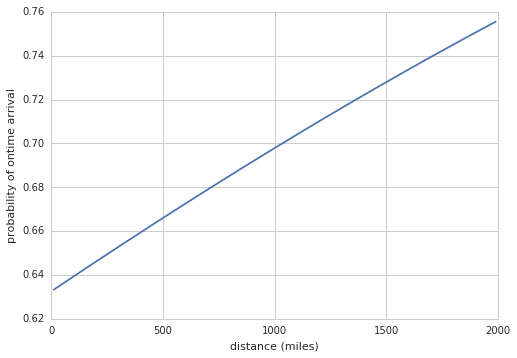

In [70]:
sns.set_style("whitegrid")
ax = plt.plot(dist, prob)
plt.xlabel('distance (miles)')
plt.ylabel('probability of ontime arrival')

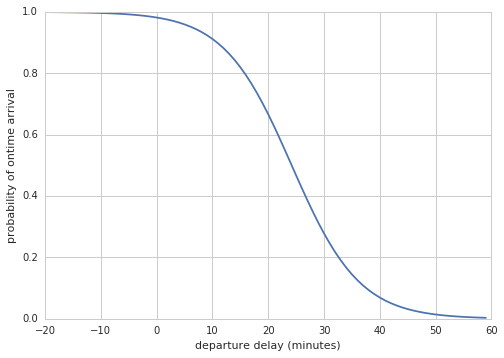

In [72]:
delay = np.arange(-20, 60, 1)
prob = [lrmodel.predict([d, 10, 500]) for d in delay]
ax = plt.plot(delay, prob)
plt.xlabel('departure delay (minutes)')
plt.ylabel('probability of ontime arrival')

<h2> Evaluate model </h2>

Evaluate on the test data

In [73]:
testquery = trainquery.replace("t.is_train_day == 'True'","t.is_train_day == 'False'")
print testquery


SELECT
  *
FROM flights f
JOIN traindays t
ON f.FL_DATE == t.FL_DATE
WHERE
  t.is_train_day == 'False' AND
  f.CANCELLED == '0.00' AND 
  f.DIVERTED == '0.00'



In [74]:
testdata = spark.sql(testquery)
examples = testdata.rdd.map(to_example)

In [79]:
lrmodel.setThreshold(0.7)
labelpred = examples.map(lambda p: (p.label, lrmodel.predict(p.features)))
def eval(labelpred):
    cancel = labelpred.filter(lambda (label, pred): pred == 0)
    nocancel = labelpred.filter(lambda (label, pred): pred == 1)
    corr_cancel = cancel.filter(lambda (label, pred): label == pred).count()
    corr_nocancel = nocancel.filter(lambda (label, pred): label == pred).count()
    
    cancel_denom = cancel.count()
    nocancel_denom = nocancel.count()
    if cancel_denom == 0:
        cancel_denom = 1
    if nocancel_denom == 0:
        nocancel_denom = 1
    return {'total_cancel': cancel.count(), \
            'correct_cancel': float(corr_cancel)/cancel_denom, \
            'total_noncancel': nocancel.count(), \
            'correct_noncancel': float(corr_nocancel)/nocancel_denom \
           }
print eval(labelpred)

{'correct_cancel': 0.7917474551623849, 'total_noncancel': 115949, 'correct_noncancel': 0.9571363271783284, 'total_cancel': 33008}
